#Adavanced machine learning
Master's Degree in Data Science (A.Y. 2021/2022)

Assignment 2

Nome: Silvia Cognome: Ranieri \ Matricola: 878067 \ \


# Predicting grayscale images of letters P - Z.

The assignment consists on the prediction of grayscale images of letters P - Z.

The data can be loaded as follows:

import pickle 

```
x_train = pickle.load(open("x_train.obj","rb"))

x_test = pickle.load(open("x_test.obj","rb"))

y_train = pickle.load(open("y_train.obj","rb"))
```

The provided data comprises the training set that can be used for the training (and for the validation) and the unlabelled balanced test set.

##Inspecting the data

any comment about data dimensionality/distribution goes here

Il dataset è composto da  14000 osservazioni di training e 8800 di test. Queste sono immagini a colori delle lettere P-Z scritte a mano. Dalla distribuzione del grafico risulta che le classi sono abbastanza bilanciate.

In [235]:

import numpy as np 
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from keras.backend import abs, sum
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder

%matplotlib inline


In [236]:
x_train = pickle.load(open("/content/x_train.obj","rb"))
x_test = pickle.load(open("/content/x_test.obj","rb"))
y_train = pickle.load(open("/content/y_train.obj","rb"))


In [237]:
print (x_train.shape)
print(y_train.shape)
print(x_test.shape)

(14000, 28, 28)
(14000,)
(8800, 28, 28)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of digit classes')

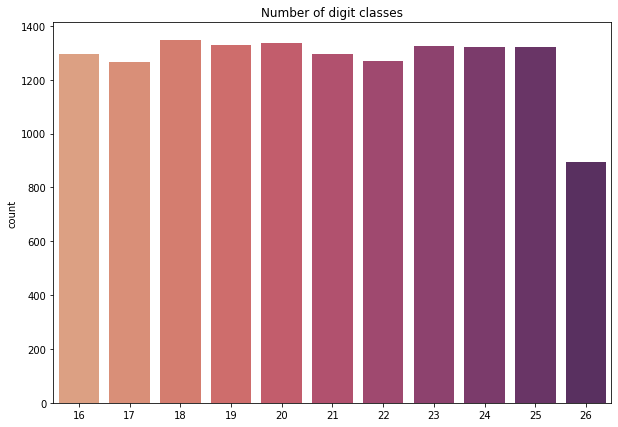

In [238]:
plt.figure(figsize=(10,7))
g = sns.countplot(y_train, palette="flare")
plt.title("Number of digit classes")

## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

Si esegue una normalizzazione della scala di grigi e si modifica la dimensione delle immagini in vettori di dimensione 784.
Dopo queste operazioni si può costruire il modello.


In [239]:
x_train = x_train.reshape(14000, 784)#28x28
x_test = x_test.reshape(8800, 784)

# Scale images into the [0 1] range
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

In [240]:
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train,27)

In [241]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [242]:
print (x_train.shape)
print(y_train.shape)
print(x_test.shape)

(14000, 784)
(14000, 27)
(8800, 784)


# 1. The resolution of the problem of supervised classification with a traditional neural network [Mandatory]
(convolutional layers should not be used) with some motivations about the choices on data processing, number and dimension of the layers, optimization algorithms and regularization (this time mandatory), and some comments about the results (as seen in class). 


## Building the network


any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

Il training set viene  suddiviso in train set (80%) e validation set (20%).


In [243]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

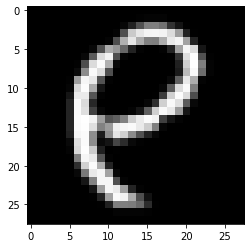

In [244]:
plt.imshow(x_train[0].reshape(28, 28))

In [245]:
print(np.asarray(range(26)))
print(y_train[0].astype('int'))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [246]:
print (x_train.shape)
print(y_train.shape)
print(x_test.shape)

(11200, 784)
(11200, 27)
(8800, 784)


Creazione delle metriche che serviranno per valutare il modello:

In [247]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

**Costruisco il modello:**

Ho provato diverse combinazioni e stabilito 4 livelli nascosti composti da 256, 128, 32, 16 unità, combinazione che otteneva miglior performance.

Ho utilizato la tecnica di dropout, perchè determinava dei risultati migliori rispetto alla tecnica di regolarizzazione semplice, sia in termini di accurancy sia per le altre metriche.
Il dropout è una tecnica in cui i neuroni selezionati casualmente vengono ignorati durante l'allenamento. Sono "abbandonati" casualmente. Ciò significa che il loro contributo all'attivazione dei neuroni a valle viene temporaneamente rimosso nel passaggio in avanti e gli eventuali aggiornamenti di peso non vengono applicati al neurone nel passaggio all'indietro.

L'effetto è che la rete diventa meno sensibile ai pesi specifici dei neuroni. Ciò a sua volta si traduce in una rete che è in grado di generalizzare meglio ed è meno probabile che si sovrapponga ai dati di addestramento.

Ho scelto di eliminare in tutti i livelli nascosti il ​​20% delle unità.

**Funzione di attivazione:** scelgo la funzione ReLU che è adatta per questo modello e in generale è una buona scelta per i livelli nascosti.

**Optimizer:** scelgo Adam perché determina prestazioni migliori.


**Metriche:** ho misurato le peformance del modello attraverso accurancy, precision e recall.

**Funzione di output:** softmax,  prestazioni migliori per questo modello. Inoltre , utile nei problemi di classificazione con n classi (n > 2) 

In [248]:

initializer = tf.keras.initializers.GlorotUniform(seed=1234)

def NeuralNetwork_Drop():
  dims = x_train.shape[1]
  nb_classes = 27
  model_d = Sequential()
  model_d.add(Dense(256, input_shape=(dims,), activation = "relu", kernel_initializer=initializer))
  model_d.add(Dense(128, activation = "relu", kernel_initializer=initializer))
  model_d.add(Dropout(0.2))
  model_d.add(Dense(32, activation = "relu", kernel_initializer=initializer))
  model_d.add(Dropout(0.2))
  model_d.add(Dense(16, activation = "relu", kernel_initializer=initializer))
  model_d.add(Dropout(0.2))
  model_d.add(Dense(nb_classes, activation = "softmax", kernel_initializer=initializer))

  from tensorflow.keras.optimizers import SGD,Adam
  model_d.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy',f1_m,precision_m, recall_m])
  return model_d

In [249]:
model_drop = NeuralNetwork_Drop()
model_drop.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 256)               200960    
                                                                 
 dense_67 (Dense)            (None, 128)               32896     
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 dense_68 (Dense)            (None, 32)                4128      
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_69 (Dense)            (None, 16)                528       
                                                                 
 dropout_34 (Dropout)        (None, 16)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results  

## Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

Per bilanciare il numero di epoche con il batchsize ho effetuato diverse prove, ho scelto 90 epoche perchè con questo valore l'accurancy del modello non aumenta e la funzione di perdita non diminuisce troppo. Per il batch size ho provato diverse dimensioni (32,64,128,256,512), miglior performance  con 128. Questi sono i risultati del modello con regolarizzazione:

In [250]:
n_epochs = 90
network_history = model_drop.fit(x_train, y_train, batch_size=128, 
                            epochs=n_epochs, verbose=2, validation_data=(x_val, y_val))

Epoch 1/90
88/88 - 2s - loss: 2.0750 - accuracy: 0.3670 - f1_m: 0.2305 - precision_m: 0.5462 - recall_m: 0.1586 - val_loss: 0.9093 - val_accuracy: 0.7500 - val_f1_m: 0.6868 - val_precision_m: 0.8958 - val_recall_m: 0.5579 - 2s/epoch - 18ms/step
Epoch 2/90
88/88 - 1s - loss: 1.1111 - accuracy: 0.6576 - f1_m: 0.6177 - precision_m: 0.8014 - recall_m: 0.5048 - val_loss: 0.6281 - val_accuracy: 0.8171 - val_f1_m: 0.8016 - val_precision_m: 0.8990 - val_recall_m: 0.7236 - 601ms/epoch - 7ms/step
Epoch 3/90
88/88 - 1s - loss: 0.8178 - accuracy: 0.7444 - f1_m: 0.7287 - precision_m: 0.8525 - recall_m: 0.6373 - val_loss: 0.4681 - val_accuracy: 0.8732 - val_f1_m: 0.8674 - val_precision_m: 0.9222 - val_recall_m: 0.8191 - 717ms/epoch - 8ms/step
Epoch 4/90
88/88 - 1s - loss: 0.6478 - accuracy: 0.8052 - f1_m: 0.7936 - precision_m: 0.8798 - recall_m: 0.7234 - val_loss: 0.3768 - val_accuracy: 0.9021 - val_f1_m: 0.9006 - val_precision_m: 0.9319 - val_recall_m: 0.8716 - 619ms/epoch - 7ms/step
Epoch 5/90
88/

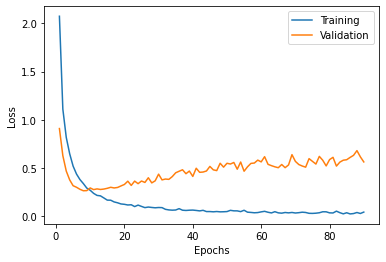

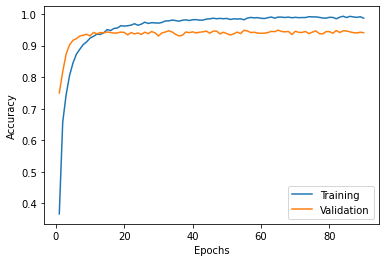

In [251]:
x_plot = list(range(1,n_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)


Dal grafico si evidenzia: la perdita diminuisce e la precisione molto simile tra training e validation, non molto overfitting.



In [252]:
# quickly get the performance score
score =  model_drop.evaluate(x_train,y_train, batch_size=128) #evaluating the models accuracy or loss,
print('test loss, test acc:', score)

88/88 [==============================] - 0s 3ms/step - loss: 0.0078 - accuracy: 0.9983 - f1_m: 0.9983 - precision_m: 0.9984 - recall_m: 0.9982
test loss, test acc: [0.007796702440828085, 0.9983035922050476, 0.9983128905296326, 0.9984019994735718, 0.9982244372367859]


In [253]:
print("\n%s: %.2f%%" % ( model_drop.metrics_names[1], score[1]*100))
print("\n%s: %.2f%%" % ( model_drop.metrics_names[2], score[2]*100))
print("\n%s: %.2f%%" % ( model_drop.metrics_names[3], score[3]*100))
print("\n%s: %.2f%%" % ( model_drop.metrics_names[4], score[4]*100))
print("\n%s: %.2f" % ( model_drop.metrics_names[0], score[0]*100))


accuracy: 99.83%

f1_m: 99.83%

precision_m: 99.84%

recall_m: 99.82%

loss: 0.78


Dal risultato si evidenzia un buon modello.

## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

In [254]:
predictions = model_drop.predict(x_test)#predicted labels
print('predictions shape:', predictions.shape)
predictions[:3]

predictions shape: (8800, 27)


array([[2.8741443e-23, 5.8817696e-23, 1.4625587e-23, 2.1191328e-22,
        8.6790027e-24, 4.2428655e-24, 2.1008814e-26, 1.6401358e-19,
        1.0357538e-22, 1.4795110e-23, 3.1329988e-22, 2.5692411e-23,
        4.8344786e-18, 8.4525073e-24, 5.5924255e-21, 1.6289125e-19,
        7.2020474e-14, 1.9390095e-12, 9.2418601e-11, 9.1953462e-20,
        6.2824229e-17, 7.2740647e-08, 9.9999964e-01, 2.1894819e-10,
        4.0689441e-10, 1.8406185e-07, 3.3024306e-17],
       [3.3938261e-38, 2.3833585e-31, 0.0000000e+00, 1.4462266e-37,
        3.4546086e-35, 1.0138797e-34, 0.0000000e+00, 1.9085561e-30,
        3.2416810e-34, 3.4891572e-38, 0.0000000e+00, 1.4685257e-36,
        9.4107035e-38, 0.0000000e+00, 9.4243843e-32, 1.0306519e-26,
        1.6317789e-28, 1.6224714e-17, 1.8628432e-24, 4.0306033e-17,
        1.0175115e-24, 3.3730190e-24, 0.0000000e+00, 1.3897010e-18,
        7.0976109e-16, 4.2441060e-20, 1.0000000e+00],
       [1.6510141e-19, 2.1375441e-24, 1.5148881e-19, 1.1038549e-21,
        

In [255]:
# generate predictions for training
trainPredict = model_drop.predict(x_train)
testPredict = model_drop.predict(x_test)
print(trainPredict)
print(testPredict)

[[8.1173091e-21 5.4860149e-22 1.1483055e-21 ... 1.4685930e-21
  9.0239915e-14 1.3192673e-08]
 [8.9993486e-13 5.9964734e-16 3.8282789e-14 ... 7.0515654e-10
  4.0898165e-05 4.3535383e-08]
 [6.4583635e-29 2.9446857e-37 2.8841597e-32 ... 1.8197219e-20
  2.0203073e-10 2.9213368e-21]
 ...
 [1.0907418e-20 4.7017297e-17 1.6149785e-20 ... 9.9999988e-01
  9.7533082e-08 4.5330562e-11]
 [1.0848638e-24 3.5977377e-20 2.6182617e-27 ... 8.7638047e-10
  1.6629708e-12 1.0000000e+00]
 [4.7489440e-18 2.1429921e-18 4.7771066e-18 ... 2.0640533e-08
  4.4154309e-05 3.8075886e-14]]
[[2.8741443e-23 5.8817696e-23 1.4625587e-23 ... 4.0689441e-10
  1.8406185e-07 3.3024306e-17]
 [3.3938261e-38 2.3833585e-31 0.0000000e+00 ... 7.0976109e-16
  4.2441060e-20 1.0000000e+00]
 [1.6510141e-19 2.1375441e-24 1.5148881e-19 ... 3.7250236e-06
  9.9995744e-01 2.4122138e-17]
 ...
 [3.3094649e-27 5.0458690e-27 2.2257803e-27 ... 6.1155454e-13
  2.6052852e-08 2.5779147e-20]
 [0.0000000e+00 2.0350936e-28 3.6587421e-37 ... 5.5030664e-

## [OPTIONAL] -- Export the predictions in the format indicated in the assignment release page.

# 2. The developement of a simple auto-encoder model  [Mandatory]
visually investigating  the reconstruction abilities of such an architecture, i.e. comparison of the input and the output (reconstructed input) (as seen in class).

## Building the network

note: performance evaluation is suggested but NOT STRICTLY REQUIRED for the autoencoder model.


Come prima cosa dobbiamo diminuire le dimensioni per un fattore di compressione pari a 24.5 quindi si passa da dimensione 784 a 32.
Avviene tramite due layers, il primo con 128 neuroni ed il secondo con  32 neuroni. Ho provato diverse combinazioni e funzioni:

**Funzione di attivazione**: Ho scelto la funzione ReLU che è adatta per questo modello e in generale è una buona scelta per i livelli nascosti.

**Optimizer**: Ho scelto Adadelta perché determina prestazioni migliori,Adadelta è un'estensione più robusta di Adagrad che adatta i tassi di apprendimento in base a una finestra mobile di aggiornamenti dei gradienti, invece di accumulare tutti i gradienti passati.

**Perdita:** Ho scelto la binary_crossentropy perchè determinava miglior performance.


**Funzione di output**: Ho scelto la funzione sigmoid che  ha performance migliori.



In [256]:
# size of encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

#input placeholder
input_img = Input(shape=(784,))

# "encoded" are the encoded representations of the input
encoded = Dense(128, activation='relu')(input_img)
encoded_1 = Dense(encoding_dim, activation='relu')(encoded)    

# "decoded" are the lossy reconstructions of the input
decoded = Dense(128, activation='relu')(encoded_1)
decoded_1 = Dense(784, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded_1)

In [257]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded_1)


# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-2](encoded_input)
decoder_layer_1 = autoencoder.layers[-1](decoder_layer)

# create the decoder model
decoder = Model(encoded_input, decoder_layer_1)


In [258]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics = ["mse"])
autoencoder.summary()


# x_train, x_train :
autoencoder_model = autoencoder.fit(x_train, x_train,
                epochs=70,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val))



Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_71 (Dense)            (None, 128)               100480    
                                                                 
 dense_72 (Dense)            (None, 32)                4128      
                                                                 
 dense_73 (Dense)            (None, 128)               4224      
                                                                 
 dense_74 (Dense)            (None, 784)               101136    
                                                                 
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
44/44 [==============================] - 1

Ho effetuato diversi tentativi e notato che dopo 70 epoche con batch size a 256, l’autoencoder raggiunge buone performance.

## Inspecting the visual results 

Investigate the reconstruction capabilities of autoencoders by comparing (in a multi-column plot) the visual representation of some input data (5 to 10 samples) with the reconstruction of such samples (output of the autoencoder).

In [259]:

encoded_imgs_train = encoder.predict(x_train)
decoded_imgs_train = decoder.predict(encoded_imgs_train)

encoded_imgs_val = encoder.predict(x_val)
decoded_imgs_val = decoder.predict(encoded_imgs_val)

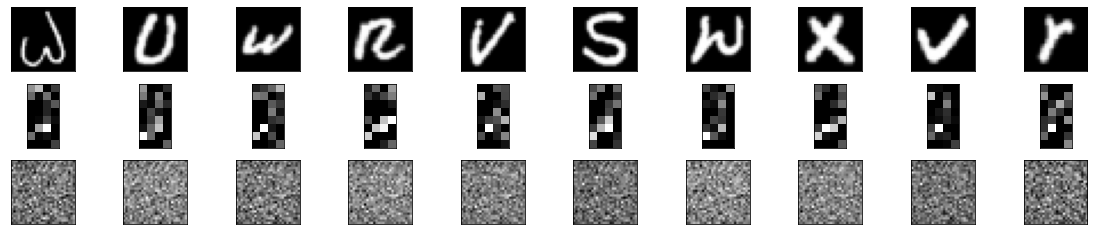

In [260]:
plt.figure(figsize=(40, 4))
for i in range(10):
    
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs_val[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 + i + 1)
    plt.imshow(decoded_imgs_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

L’architettura dell’autoencoder riesce quindi a comprimere e ricostruire le immagini con una perdita minima come si vede dal grafico.

# 3. [OPTIONAL] The use and evaluation of the encoded representation generated by the auto-encoder to solve the problem of supervised classification.

the idea is to take the encoded representation generated by the autoencoder developed in Section 2., and classify letters based on this representation.

In other words, instead of feeding images directly thought a classifier (can be a Neural Network, but also a machine learning algorithm such as SVM, RF..), you can try to use the encoded representations as input for the classification task.

Briefly compare the results with those obtained in Section 1.